# Time Series Forecasting: Retail Giant Sales Forecasting Assignment

## Import required packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Import time series data: Global Superstore Data

#### Link to use relative path to input data set based on your directory structure:
https://stackoverflow.com/questions/50119792/python-import-excel-file-using-relative-path

This is a change in editor, test it in github desktop

In [2]:
root_df = pd.read_csv(r'./../data/raw/Global+Superstore+Data.csv')
print(root_df.shape)
root_df.head()

(51290, 5)


,Order Date,Segment,Market,Sales,Profit
0,31-07-2012,Consumer,US,2309.650,762.1845
1,05-02-2013,Corporate,APAC,3709.395,-288.7650
2,17-10-2013,Consumer,APAC,5175.171,919.9710
3,28-01-2013,Home Office,EU,2892.510,-96.5400
4,05-11-2013,Consumer,Africa,2832.960,311.5200


In [3]:
root_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  51290 non-null  object 
 1   Segment     51290 non-null  object 
 2   Market      51290 non-null  object 
 3   Sales       51290 non-null  float64
 4   Profit      51290 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


In [4]:
root_df.isnull().sum()

Order Date    0
Segment       0
Market        0
Sales         0
Profit        0
dtype: int64

#### Inference from Above: There are no null values in our data and thus Missing Value Treatment not necessary

In [5]:

root_df.rename(columns={ "Order Date" : 'Order_Date'}, inplace=True)
root_df['Order_Date'] = pd.to_datetime(root_df['Order_Date']).dt.to_period('m')
print(type(root_df.Order_Date[0]))
root_df.sort_values(by='Order_Date',inplace=True)
print(root_df.shape)

<class 'pandas._libs.tslibs.period.Period'>
(51290, 5)


#### Above Code Explanation:
- We converted Date in Year-Month Format and the object to 'Period' object
- And sorted dataframe by 'Order_Date':

In [6]:
root_df.head(2)

,Order_Date,Segment,Market,Sales,Profit
15262,2011-01,Corporate,EU,139.65,15.30
26744,2011-01,Consumer,EU,88.44,15.84


In [7]:
root_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51290 entries, 15262 to 541
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   Order_Date  51290 non-null  period[M]
 1   Segment     51290 non-null  object   
 2   Market      51290 non-null  object   
 3   Sales       51290 non-null  float64  
 4   Profit      51290 non-null  float64  
dtypes: float64(2), object(2), period[M](1)
memory usage: 2.3+ MB


In [8]:
# Create another column named "Market-Segment" which has both Market and Segment field into a single field.
root_df['Market_Segment'] = root_df.agg('{0[Market]}-{0[Segment]}'.format, axis=1)
print(root_df.head(2))
print(root_df.tail(2))

      Order_Date    Segment Market   Sales  Profit Market_Segment
15262    2011-01  Corporate     EU  139.65   15.30   EU-Corporate
26744    2011-01   Consumer     EU   88.44   15.84    EU-Consumer
      Order_Date   Segment Market     Sales    Profit  Market_Segment
21163    2014-12  Consumer   APAC  185.0688 -102.8712   APAC-Consumer
541      2014-12  Consumer  LATAM  664.5600    6.6000  LATAM-Consumer


In [9]:
#We observe that there are now 21 market segments:
root_df.Market_Segment.value_counts().shape

(21,)

In [10]:
root_df.Market_Segment.value_counts()

APAC-Consumer         5699
LATAM-Consumer        5321
US-Consumer           5191
EU-Consumer           5186
APAC-Corporate        3283
EU-Corporate          3077
LATAM-Corporate       3053
US-Corporate          3020
EMEA-Consumer         2538
Africa-Consumer       2381
APAC-Home Office      2020
LATAM-Home Office     1920
US-Home Office        1783
EU-Home Office        1737
EMEA-Corporate        1574
Africa-Corporate      1312
EMEA-Home Office       917
Africa-Home Office     894
Canada-Consumer        202
Canada-Corporate       110
Canada-Home Office      72
Name: Market_Segment, dtype: int64

<AxesSubplot:>

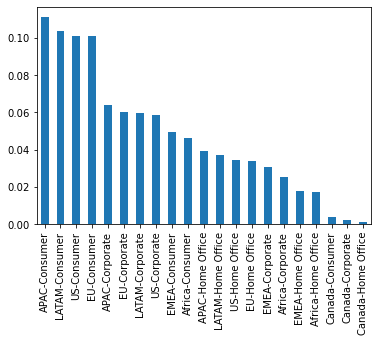

In [11]:
root_df.Market_Segment.value_counts(normalize=True).plot.bar()

In [12]:
root_df.head(2)

,Order_Date,Segment,Market,Sales,Profit,Market_Segment
15262,2011-01,Corporate,EU,139.65,15.30,EU-Corporate
26744,2011-01,Consumer,EU,88.44,15.84,EU-Consumer


In [13]:
root_df_pivot= root_df.pivot_table(index='Order_Date',columns=('Market_Segment'),values='Profit',aggfunc='sum')
print(root_df_pivot.shape)
root_df_pivot.head()

(48, 21)


Market_Segment,APAC-Consumer,APAC-Corporate,APAC-Home Office,Africa-Consumer,Africa-Corporate,Africa-Home Office,Canada-Consumer,Canada-Corporate,Canada-Home Office,EMEA-Consumer,...,EMEA-Home Office,EU-Consumer,EU-Corporate,EU-Home Office,LATAM-Consumer,LATAM-Corporate,LATAM-Home Office,US-Consumer,US-Corporate,US-Home Office
Order_Date,,,,,,,,,,,,,,,,,,,,,
2011-01,2254.4898,-173.7264,230.2656,265.539,520.026,391.515,447.33,12.57,NaN,-2952.594,...,392.526,2259.8670,841.3875,2534.568,540.44312,1021.05924,-26.59744,2465.8368,643.3689,1233.9329
2011-02,4627.8531,3600.7776,617.5407,-201.888,-31.689,825.606,26.43,9.24,87.99,464.160,...,368.070,-783.9945,2234.4060,162.255,1227.86616,814.03020,-356.80440,1853.5541,421.9256,553.9467
2011-03,2337.8319,3634.9365,205.1052,919.074,244.437,83.430,82.47,NaN,84.03,706.380,...,-15.570,1273.7100,2206.5960,269.745,2427.39612,178.66400,769.88400,204.2007,127.4696,-268.9314
2011-04,633.6423,90.7521,603.8478,381.315,941.751,417.618,55.08,6.51,NaN,121.353,...,-456.510,2980.0065,981.1470,130.371,1368.82948,872.64068,-554.22952,1434.8636,494.7315,2723.4358
2011-05,3838.9500,1028.4489,102.0315,-39.981,490.650,39.180,0.87,NaN,NaN,172.554,...,-33.591,673.0080,1719.0600,443.310,1749.39200,134.87252,-397.95600,833.9433,2912.7976,145.7781


In [14]:
print(root_df_pivot.shape)

(48, 21)


In [15]:
#root_df_pivot.describe()
train_len=42
test_len=6

In [16]:
train_root_df_pivot=root_df_pivot[0:train_len] #42 Rows
test_root_df_pivot=root_df_pivot[train_len:] # 6 Rows

In [17]:
print(train_root_df_pivot.shape)
print(test_root_df_pivot.shape)
train_root_df_pivot.head()

(42, 21)
(6, 21)


Market_Segment,APAC-Consumer,APAC-Corporate,APAC-Home Office,Africa-Consumer,Africa-Corporate,Africa-Home Office,Canada-Consumer,Canada-Corporate,Canada-Home Office,EMEA-Consumer,...,EMEA-Home Office,EU-Consumer,EU-Corporate,EU-Home Office,LATAM-Consumer,LATAM-Corporate,LATAM-Home Office,US-Consumer,US-Corporate,US-Home Office
Order_Date,,,,,,,,,,,,,,,,,,,,,
2011-01,2254.4898,-173.7264,230.2656,265.539,520.026,391.515,447.33,12.57,NaN,-2952.594,...,392.526,2259.8670,841.3875,2534.568,540.44312,1021.05924,-26.59744,2465.8368,643.3689,1233.9329
2011-02,4627.8531,3600.7776,617.5407,-201.888,-31.689,825.606,26.43,9.24,87.99,464.160,...,368.070,-783.9945,2234.4060,162.255,1227.86616,814.03020,-356.80440,1853.5541,421.9256,553.9467
2011-03,2337.8319,3634.9365,205.1052,919.074,244.437,83.430,82.47,NaN,84.03,706.380,...,-15.570,1273.7100,2206.5960,269.745,2427.39612,178.66400,769.88400,204.2007,127.4696,-268.9314
2011-04,633.6423,90.7521,603.8478,381.315,941.751,417.618,55.08,6.51,NaN,121.353,...,-456.510,2980.0065,981.1470,130.371,1368.82948,872.64068,-554.22952,1434.8636,494.7315,2723.4358
2011-05,3838.9500,1028.4489,102.0315,-39.981,490.650,39.180,0.87,NaN,NaN,172.554,...,-33.591,673.0080,1719.0600,443.310,1749.39200,134.87252,-397.95600,833.9433,2912.7976,145.7781


In [18]:
train_root_df_pivot.describe()# Check

Market_Segment,APAC-Consumer,APAC-Corporate,APAC-Home Office,Africa-Consumer,Africa-Corporate,Africa-Home Office,Canada-Consumer,Canada-Corporate,Canada-Home Office,EMEA-Consumer,...,EMEA-Home Office,EU-Consumer,EU-Corporate,EU-Home Office,LATAM-Consumer,LATAM-Corporate,LATAM-Home Office,US-Consumer,US-Corporate,US-Home Office
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,38.000000,34.000000,24.000000,42.000000,...,41.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,4400.894243,2574.919807,1511.088314,957.707000,412.617571,377.221071,225.987632,90.980294,118.003750,423.960286,...,84.231366,3699.977143,2216.299429,1224.456536,2295.555697,1122.633016,818.398941,2686.740912,1754.199083,1132.065762
std,2328.343041,1381.381825,1541.976104,1270.143926,790.028612,768.526445,286.348653,164.936757,285.647164,1138.184151,...,659.373878,2228.977594,1619.735425,1162.551208,1588.659231,1002.365692,968.879479,2747.942085,1902.991919,1287.900959
min,262.244700,-173.726400,-2846.224500,-1485.021000,-712.866000,-1445.550000,0.870000,0.240000,0.000000,-2952.594000,...,-2114.334000,-783.994500,-947.035500,-2046.046500,-323.287160,-523.865680,-2481.398680,-2620.836500,-2397.378900,-1705.256800
25%,2606.027925,1764.802650,525.940875,120.783750,-195.930750,-81.359250,31.342500,8.610000,8.392500,-37.533000,...,-218.802000,2265.157125,1092.880875,448.334250,1097.027580,321.363220,326.676370,1163.400500,644.564125,393.003925
50%,4409.488050,2473.137150,1374.097350,946.701000,325.050000,316.047000,83.280000,31.845000,28.260000,245.155500,...,-15.570000,3462.551250,2071.168500,1041.083250,2307.308000,987.732160,802.030000,2043.057400,1198.804000,981.146700
75%,5502.655875,3524.855925,2401.074450,1375.594500,845.398500,800.584500,337.492500,86.047500,91.102500,928.150500,...,368.070000,5327.909250,2902.141875,1845.573750,3160.176970,1806.625410,1394.267640,3812.714725,2683.716300,1576.315325
max,10385.859300,5881.093200,5532.463800,5530.560000,3350.991000,2230.371000,1121.220000,813.570000,1392.810000,3415.698000,...,1656.462000,10350.213000,8043.963000,4116.442500,6894.627520,3778.776920,2791.452400,9977.971000,9230.261000,4882.353600


#### Calculate COV
-Create a new dataframe to hold COV values for each 21 Market Segments

In [19]:
cov=pd.DataFrame(columns=['Market_Segment','COV'])

In [20]:
cov.head()

,Market_Segment,COV


In [21]:
for i in train_root_df_pivot.columns:
    temp={'Market_Segment':i, "mean_profit":np.mean(train_root_df_pivot[i]), "stddev_profit":np.std(train_root_df_pivot[i]), "COV":np.std(train_root_df_pivot[i]/np.mean(train_root_df_pivot[i]))}
    cov=cov.append(temp,ignore_index=True)

In [22]:
cov.sort_values(by="COV",inplace=True)

In [23]:
cov.head(21)

,Market_Segment,COV,mean_profit,stddev_profit
0,APAC-Consumer,0.522725,4400.894243,2300.457687
1,APAC-Corporate,0.530051,2574.919807,1364.837734
12,EU-Consumer,0.595215,3699.977143,2202.282289
15,LATAM-Consumer,0.683770,2295.555697,1569.632686
13,EU-Corporate,0.722076,2216.299429,1600.336696
16,LATAM-Corporate,0.882177,1122.633016,990.360880
14,EU-Home Office,0.938072,1224.456536,1148.627937
2,APAC-Home Office,1.008219,1511.088314,1523.508658
18,US-Consumer,1.010530,2686.740912,2715.031412
19,US-Corporate,1.071829,1754.199083,1880.200775


In [24]:
cov.tail(2)

,Market_Segment,COV,mean_profit,stddev_profit
10,EMEA-Corporate,6.355024,182.642643,1160.698430
11,EMEA-Home Office,7.732073,84.231366,651.283095


#### Inference From Above: 
- **APAC-Consumer**	 is the market segment with least COV indicating the most profitable market segment

## MODEL BUILDING PROCESS USING 'APAC-Consumer' MARKET SEGMENT

In [25]:
#This is "PROFIT" Time Series For "APAC-Consumer" Market-Segment. We want "Sales" Time Series for the same Market-Segment
temp_df=root_df_pivot['APAC-Consumer']
print(temp_df.shape)
temp_df.head()

(48,)


Order_Date
2011-01    2254.4898
2011-02    4627.8531
2011-03    2337.8319
2011-04     633.6423
2011-05    3838.9500
Freq: M, Name: APAC-Consumer, dtype: float64

In [26]:
df1=root_df[root_df['Market_Segment']=='APAC-Consumer']
print(df1.shape)
df1.head()

(5699, 6)


,Order_Date,Segment,Market,Sales,Profit,Market_Segment
1080,2011-01,Consumer,APAC,1429.050,371.490,APAC-Consumer
9203,2011-01,Consumer,APAC,219.780,59.340,APAC-Consumer
19331,2011-01,Consumer,APAC,342.510,54.600,APAC-Consumer
26270,2011-01,Consumer,APAC,102.762,1.842,APAC-Consumer
14830,2011-01,Consumer,APAC,420.420,147.000,APAC-Consumer


In [27]:
data=df1[['Order_Date','Sales']]

In [28]:
data.head(15)

,Order_Date,Sales
1080,2011-01,1429.050
9203,2011-01,219.780
19331,2011-01,342.510
26270,2011-01,102.762
14830,2011-01,420.420
2825,2011-01,1917.240
5901,2011-01,285.780
36412,2011-01,98.220
27515,2011-01,47.100
1177,2011-01,1157.580


#### Aggregate data on Order_Date
   

In [29]:
data=data.groupby(['Order_Date']).sum()
print(data.shape)
data.head()

(48, 1)


,Sales
Order_Date,
2011-01,18821.9898
2011-02,23313.3531
2011-03,26518.4919
2011-04,12046.0923
2011-05,25941.9000


In [30]:
#You can see the index datetype is a PeriodIndex:
data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 48 entries, 2011-01 to 2014-12
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


#### Convert Order_Date to pandas 'DateTime' format for further analysis.

In [31]:
data=data.to_timestamp()

In [32]:
#You can see the index datetype is now a DateTimeIndex:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2011-01-01 to 2014-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [33]:
train=data[0:train_len]
test=data[train_len:]
print(train.shape)
print(test.shape)

(42, 1)
(6, 1)


In [34]:
train.head()

,Sales
Order_Date,
2011-01-01,18821.9898
2011-02-01,23313.3531
2011-03-01,26518.4919
2011-04-01,12046.0923
2011-05-01,25941.9000


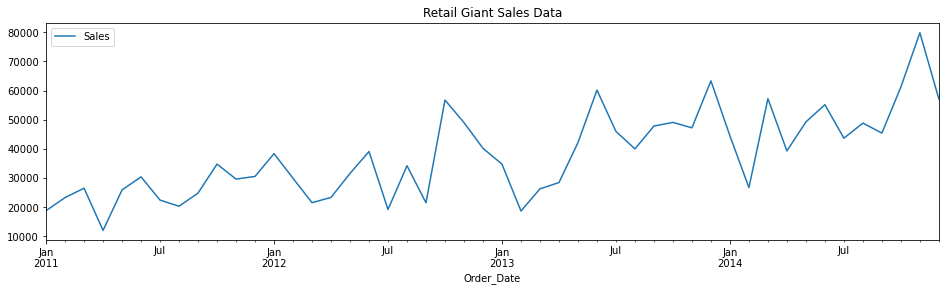

In [35]:
data.plot(figsize=(16, 4))
plt.legend(loc='best')
plt.title('Retail Giant Sales Data')
plt.show()

## Outlier detection

In [36]:
data.describe()

,Sales
count,48.000000
mean,37849.035425
std,14671.281955
min,12046.092300
25%,26209.485300
50%,36578.300400
75%,48088.354575
max,79834.429500


### Box plot and interquartile range

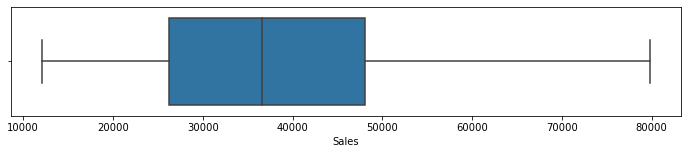

In [37]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['Sales'],whis=1.5) # whiz=multiplication factor with IQR(Interquartile Range)
# IQR=48088.354575-26209.485300=21878.869274999997
# IQR*1.5=21878.869274999997*1.5=32818.30391249999
# Total upper limit= 48088.354575+32818.30391249999=80906.65848749998

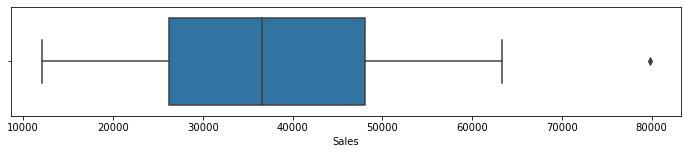

In [38]:
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data['Sales'],whis=1)

### Histogram plot for 'Sales'

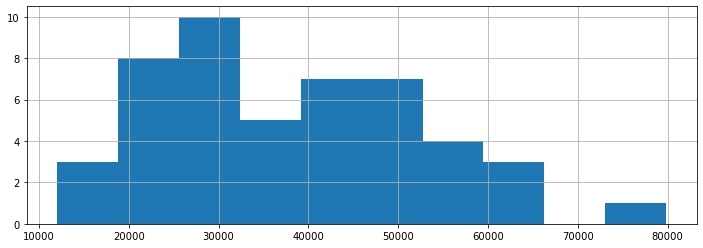

In [39]:
fig = data.Sales.hist(figsize = (12,4))

## Time series Decomposition
- 4 Year Period or 48 Months for the Retail Giant Sales data set

### Additive seasonal decomposition in Python:

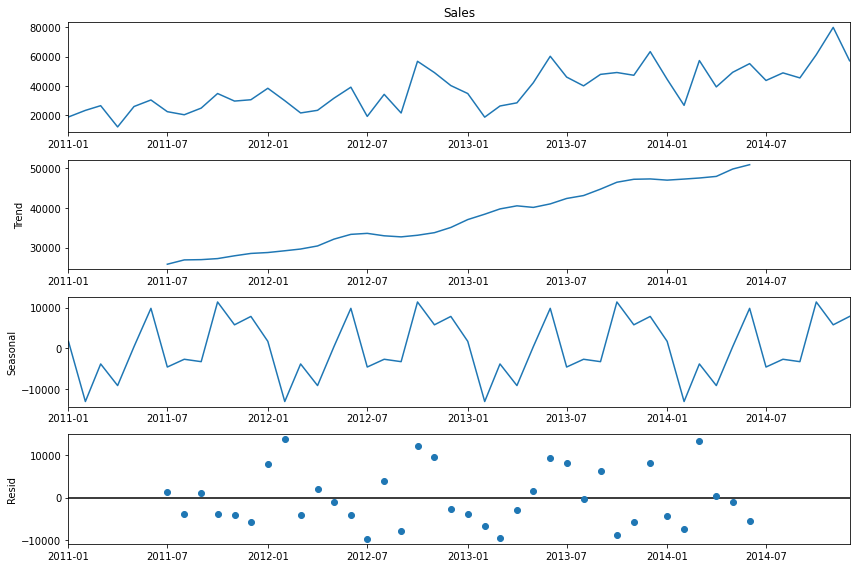

In [40]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Sales, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

####  Inference from additive decomposotion:
- Residuals still shows some seasonality pattern

### Multiplicative seasonal decomposition in Python:

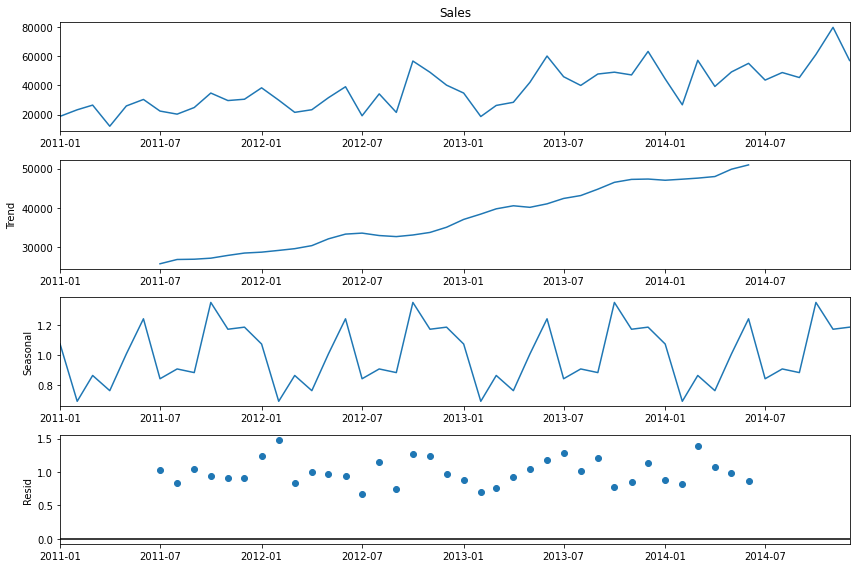

In [41]:
decomposition = sm.tsa.seasonal_decompose(data.Sales, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

####  Inference from multiplicative decomposition:
- Residuals now doesn't show some seasonality pattern but less compared to additive method.


# Build and evaluate time series forecast:
- Before building various models, we go to our flow chart of which models to use and get an intuition as to which models will be better of in our case of retail giant sales forecasting.

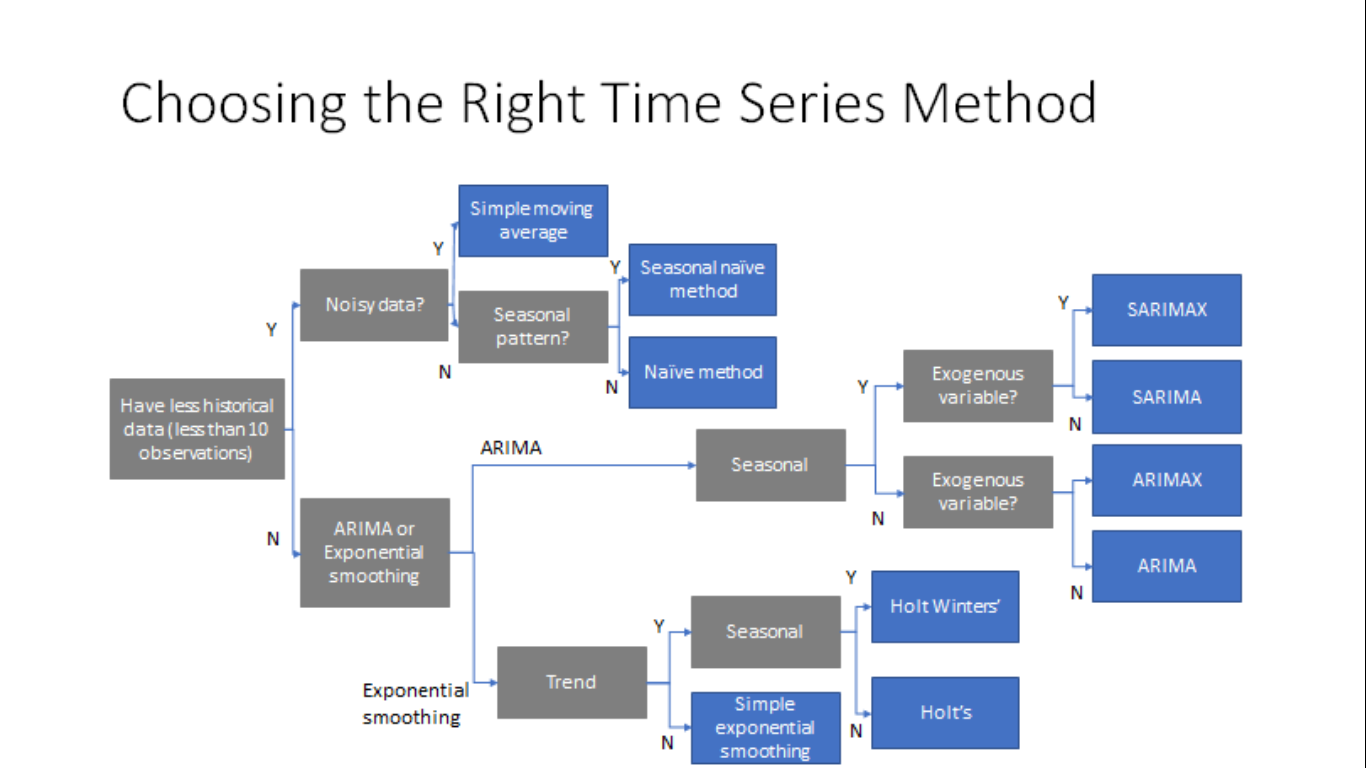

#### Inference from above flow chart and our plot of Time Series Retail giant sales data:
- Our Time Series data has more than 10 observations. Here in our case we have observations for 48 months with seasonality of 12 months.
- Our Time Series Data has all three components of Level, Trend and Seasonality.
- Our Time Series Data doesn't have any other exogenous variable.
#### Which model to use?
- Thus we can use both ARIMA or Exponential Smoothing Methods.
- Here we conclude that in exponential smoothing we use **"Holt Winters Method"** and in ARIMA method we use the "**SARIMA**" method as these two methods capture all three components of Level, Trend and Seasonality in our Time Series Data.
- Lets however go step by step with all models and check if our prediction is true.

## Exponential smoothing methods

## Simple exponential smoothing: Only Level is captured------->

In [42]:
print(len(test))

6


In [43]:
model = SimpleExpSmoothing(train['Sales'])
# model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.24674418604651163, 'smoothing_trend': nan, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 18821.989799999996, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast for 'Simple Exponential Smoothing'

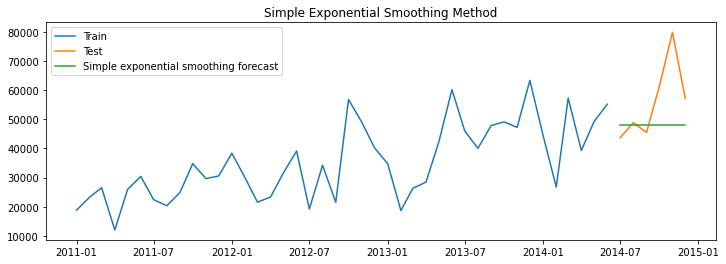

In [44]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

### Calculate RMSE and MAPE for 'Simple Exponential Smoothing'

In [45]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ses['ses_forecast'])/test['Sales'])*100,2)

results = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
# results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,14627.34,15.74


## Holt's method : Captures Level and Trend Components

In [46]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
# model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2642857142857143, 'smoothing_trend': 0.19220779220779222, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 18821.989799999996, 'initial_trend': 4491.3633000000045, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


#### Inference on Hyperparameter tuning for model For Holts Method to capture Level and Trend:
- we pass as array, as the method takes an array
- seasonal_periods:12 indicates monthly season. However in this holts method seasonality is not captured but yet we just keep it that way.
- trend:'additive' as we see and know that the wholoe dataset follows a linear trend and for linear data we use additive decomposition technique
- seasonal: None as in this model we don't plan to capture seasonality component. We capture that in the next segment.

#### On Fitting the Model:
- smoothing_level: Alpha: indicates **Level** smoothing parameter which is how much weight to give the immediate actual observation? In our case its `0.26`
- smoothing slope: Beta: indicates **Trend** smoothing parameter which is how much weight to give the immediate actual observation? In our case its `0.19`
- optimized: If set to true, we need not explicitly give Alpha and Beta as the method computes it for us. If set to false we need to provide values for alpha and beta. In our case above we are setting it to True.

#### Comprehension of model_fit.params
- initial_level: `18821.989799999996` says that the initial level of no of Sales in our data set was `18821.989799999996`.
- initial_trend: `4491.3633000000045` is the initial slope i.e the Delta increase to each month is around `4491` units. Increase from one month to the next is `4491` units. Here its an additive slope
- use_boxcox:False indicates no boxcox transformation is used.
- lambda:False
- remove_bias:False.

### Plot train, test and forecast for Holt's Method:

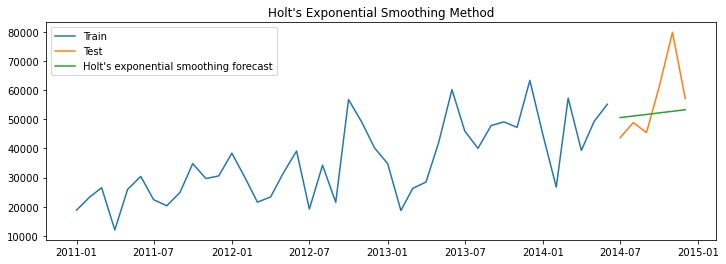

In [47]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

### Calculate RSME and MAPE for Holt's Method:

In [48]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_holt['holt_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,14627.34,15.74
0,Holt's exponential smoothing method,12403.84,14.93


## Holt Winters' Additive method with Level, Trend and Seasonality

#### Additve and Multiplicative Model, What to use when?
#### Additive:
- Additive is used when Seasonality(S) is not a function of level(L) i.e seasonality remains constant in each level. What do you mean by that?
- For eg: In Ice Cream Sales Time Series, Seasonality remains constant in each level. i.e The sales of ice cream remains fixed for each summer and doesn't increase year on year. You just need to add the fixed extra summer sales amount to predict the next year summer season sales amount. This is additive in nature.
- Here mathematically the peak and the Troughs difference amount remains the same and thus we use additive model.

#### Multiplicative:
- Multiplicative is used when Seasonality(S) is a function of Level(L). i.e seasonality increases with increase in each level(time period)
- For eg: In Air Passengers Forecasting Problem, the no of passengers for each season increases with increase in population and demand for Air Travel. This is Multiplicative in nature.
- Here the difference number of passengers between Peak and Troughs keeps increases with increase in Level i.e Time Period i.e Every Year. Thus we use multiplicative model.

#### The Choice of additive or multiplicative model depends entirely on the business use case!!
#### In our Retail Giant Sales Forecasting problem we use 'Multiplicative' Model as the no of sales for each season increases with time, This means, that for every seasonal pattern in the time series, the distance between the peaks and the troughs keeps increasing. This is multiplicative in nature.

In [49]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.07571428571428572, 'smoothing_trend': 0.010816326530612248, 'smoothing_seasonal': 0.1026984126984127, 'damping_trend': nan, 'initial_level': 34110.965325, 'initial_trend': 730.4167145833331, 'initial_seasons': array([-15288.975525, -10797.612225,  -7592.473425, -22064.873025,
        -8169.065325,  -3712.033725, -11679.370425, -13779.891825,
        -9250.570425,    676.322775,  -4462.610625,  -3556.103925]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


#### Inference:
- 'initial_seasons' shows negative numbers in an additive model.

### Plot train, test and forecast for Holt Winter's Additive Model:

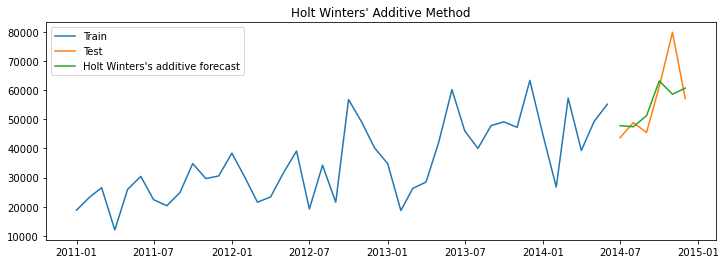

In [50]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

### Calculate RMSE and MAPE for Holt Winter's Additive Model:

In [51]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwa['hw_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,14627.34,15.74
0,Holt's exponential smoothing method,12403.84,14.93
0,Holt Winters' additive method,9306.82,10.17


## Holt Winter's Multiplicative method with Level, Trend and Seasonality

In [52]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.040357142857142855, 'smoothing_trend': 0.0001, 'smoothing_seasonal': 0.13709183673469388, 'damping_trend': nan, 'initial_level': 34110.965325, 'initial_trend': 730.4167145833331, 'initial_seasons': array([0.55178708, 0.68345627, 0.77741839, 0.35314428, 0.76051498,
       0.8911777 , 0.65760657, 0.5960275 , 0.72880948, 1.01982714,
       0.86917372, 0.89574895]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


#### Inference:
- Note we Use seasonal='mul' in Holt Winter's Multiplicative model. Thats the only change w.r.t additive model.
- 'initial_seasons' shows negative numbers in an additive model
- 'initial_seasons' shows a number less than 1, i.e the coefficients in a a multiplicative model

### Plot train, test and forecast for Holt Winter's Multiplicative Model:

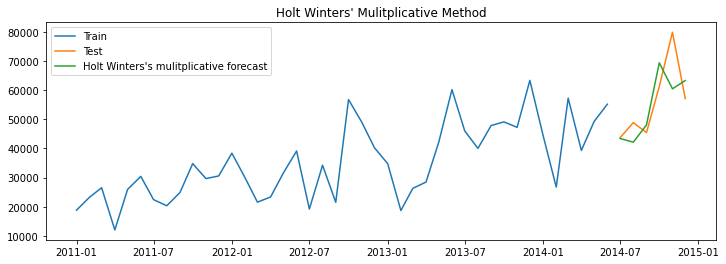

In [53]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

### Calculate RMSE and MAPE for Holt Winter's Multiplicative Model:

In [54]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwm['hw_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,14627.34,15.74
0,Holt's exponential smoothing method,12403.84,14.93
0,Holt Winters' additive method,9306.82,10.17
0,Holt Winters' multiplicative method,9423.23,11.43


# Next we will plot the ARIMA set of techniques:
1. AR model
2. MA model
3. ARMA model
4. ARIMA model
5. SARIMA model

### We will First test whether our Sales Time Series Data is stationary or not:
- Yes we know by plot that sales data is not stationary(i.e no constant mean and variance) but will test again for intuition

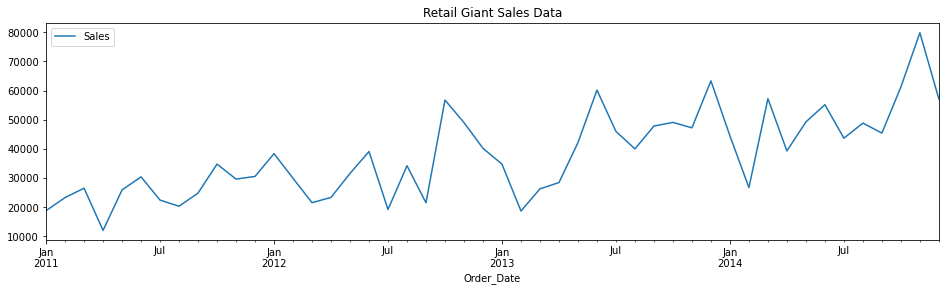

In [55]:
data.plot(figsize=(16, 4))
plt.legend(loc='best')
plt.title('Retail Giant Sales Data')
plt.show()

### Augmented Dickey-Fuller (ADF) test

In [56]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Sales'])
print(adf_test)
print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

(-3.3760244736258036, 0.011803859657119728, 0, 47, {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}, 804.80930070885)
ADF Statistic: -3.376024
Critical Values @ 0.05: -2.93
p-value: 0.011804


#### Points to Note about ADF Test:
- H0= Null Hypothesis: The Series is NOT  Stationary
- H1= Alternate Hypothesis: The Series is Stationary
- If p-value<=0.05, (this is at 5%), reject Null Hypothesis(H0) and state that Series is Stationary.

In Above Sales data set:
- ADF statistic  of -3.376024< critical value of (-2.93). Thus its observed that the statistic value is under Critical Value
- Also pvalue of 0.011804 is < 0.05 , Thus we reject null Hypothesis and state that series is stationary.

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [57]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['Sales'])
print(kpss_test)
print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

(0.5770764651955994, 0.024720321345854595, 10, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Statistic: 0.577076
Critical Values @ 0.05: 0.46
p-value: 0.024720


#### Points to Note about KPSS  Test:
- H0= Null Hypothesis: The Series is Stationary
- H1= Alternate Hypothesis: The Series is NOT Stationary
- If p-value<=0.05, (this is at 5%), reject Null Hypothesis(H0) and state that Series is NOT Stationary.

In Above Airline passenger data set:
- KPSS statistic  of 0.577076 > critical value of (0.46). Thus its observed that the statistic value is way above Critical Value
- Also pvalue of 0.024720 is < 0.05 , Thus we reject null Hypothesis and state that series is NOT stationary.

#### Here ADF test showed us that series is stationary but KPSS Test showed us that series is NOT Stationary. 
- So lets use Box cox transform and first order differencing to make series stationary and check with ADF and KPSS tests again.

###  Box Cox transformation to make variance constant

In [58]:
print(data.index.shape) # 48 months

(48,)


#### Passengers time series graph BEFORE boxcox transform:
- You can see that the variance is small in the intial years and large in the later years

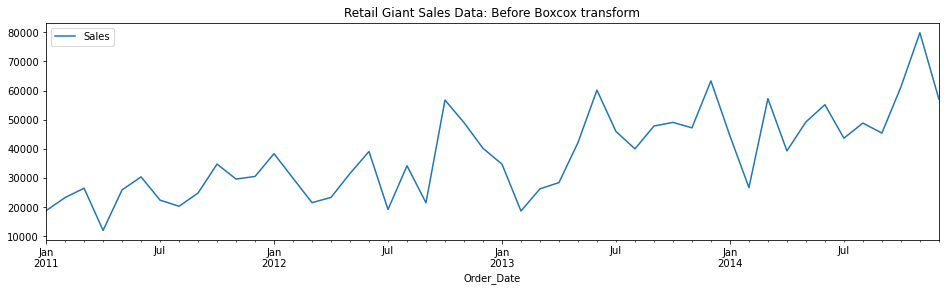

In [59]:
data.plot(figsize=(16, 4))
plt.legend(loc='best')
plt.title('Retail Giant Sales Data: Before Boxcox transform')
plt.show()

####  Passengers time series graph AFTER boxcox transform:
- You can see that the variance is CONSTANT in the initial years as well as in the later years.

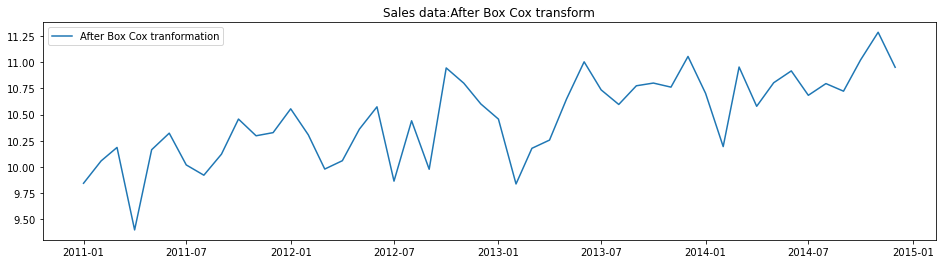

In [60]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Sales'], lmbda=0), index = data.index)

plt.figure(figsize=(16,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('Sales data:After Box Cox transform')
plt.show()

### Differencing to remove trend or to make Trend Constant over time
- Note the order of operations: you first do a boxcox to get constant variance and than perform differencing to get constant mean

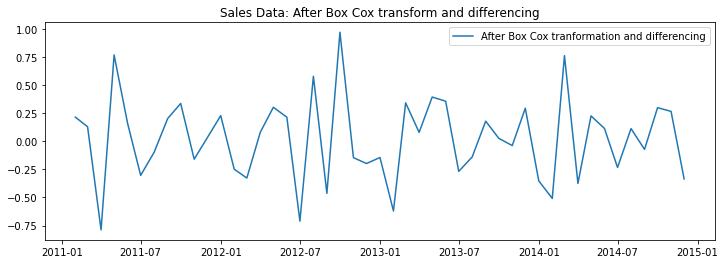

In [61]:
# Notice use of shift() method to get the next observation or record
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('Sales Data: After Box Cox transform and differencing')
plt.show()

In [62]:
data_boxcox_diff.isnull().sum()

1

In [63]:
#Notice null value at the beginning:
data_boxcox_diff.head(3)

Order_Date
2011-01-01         NaN
2011-02-01    0.214000
2011-03-01    0.128816
Freq: MS, dtype: float64

In [64]:
data_boxcox_diff.dropna(inplace=True)

In [65]:
data_boxcox_diff.isnull().sum()

0

In [66]:
data_boxcox_diff.head(3)

Order_Date
2011-02-01    0.214000
2011-03-01    0.128816
2011-04-01   -0.789102
Freq: MS, dtype: float64

### Augmented Dickey-Fuller (ADF) test

In [67]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.535011
Critical Values @ 0.05: -2.95
p-value: 0.000170


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [68]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.156456
Critical Values @ 0.05: 0.46
p-value: 0.100000


#### Inference: With both the ADF and KPSS above tests we now conclude that the time series is now a stationary time series

## Autocorrelation function (ACF): Used to calculate value of 'q' =window size =the MA component
-  'q' which is the MA component of the order(0,0,0) as the highest lag beyond which autocorrelation dies down.

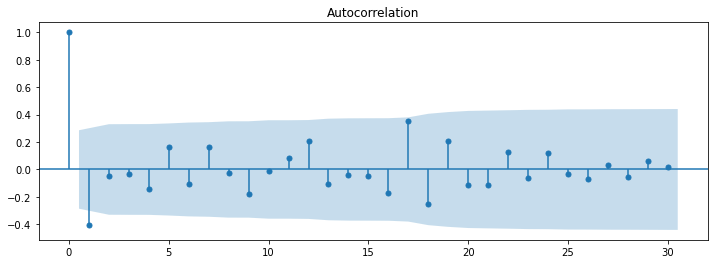

In [69]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

## Partial autocorrelation function (PACF): Used to calculate value of 'p'=lag order=no of lag variables = AR component
- 'p' Select p as the highest lag where partial autocorrelation is significantly high.

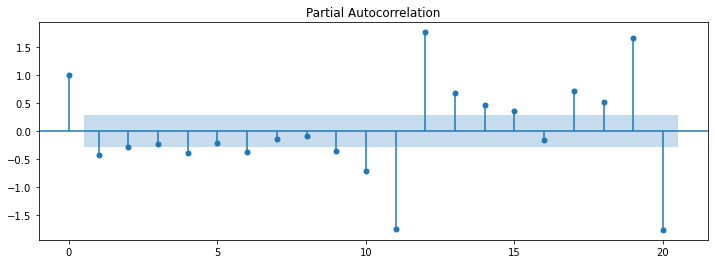

In [70]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 20)
plt.show()

In [71]:
#Non Stationary Data with boxcox but without differencing done:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
print(train_data_boxcox.shape)
print(test_data_boxcox.shape)
# Stationary Time Series/ Data with boxcox and differencing done to have constant variance and mean respectively.
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]
print(train_data_boxcox_diff.shape)
print(test_data_boxcox_diff.shape)

(42,)
(6,)
(41,)
(6,)


#### Observation
- For train_data_boxcox_diff we are substracting 1 from train_len, cz we dropped first row in train_data_boxcox_diff cz it had to be dropped as we cannot/will not calculate diff for the very first row.

In [72]:
train_data_boxcox_diff

Order_Date
2011-02-01    0.214000
2011-03-01    0.128816
2011-04-01   -0.789102
2011-05-01    0.767119
2011-06-01    0.158548
2011-07-01   -0.303937
2011-08-01   -0.098320
2011-09-01    0.201126
2011-10-01    0.335976
2011-11-01   -0.159845
2011-12-01    0.030117
2012-01-01    0.227734
2012-02-01   -0.248683
2012-03-01   -0.327663
2012-04-01    0.079944
2012-05-01    0.301872
2012-06-01    0.213622
2012-07-01   -0.710884
2012-08-01    0.577494
2012-09-01   -0.463894
2012-10-01    0.969434
2012-11-01   -0.146063
2012-12-01   -0.198531
2013-01-01   -0.144942
2013-02-01   -0.620558
2013-03-01    0.341112
2013-04-01    0.078691
2013-05-01    0.392955
2013-06-01    0.355907
2013-07-01   -0.268628
2013-08-01   -0.139388
2013-09-01    0.178702
2013-10-01    0.026014
2013-11-01   -0.038982
2013-12-01    0.293485
2014-01-01   -0.353341
2014-02-01   -0.508883
2014-03-01    0.761118
2014-04-01   -0.375717
2014-05-01    0.225410
2014-06-01    0.113222
Freq: MS, dtype: float64

In [73]:
train_data_boxcox_diff.head()

Order_Date
2011-02-01    0.214000
2011-03-01    0.128816
2011-04-01   -0.789102
2011-05-01    0.767119
2011-06-01    0.158548
Freq: MS, dtype: float64

## Auto regression method (AR)
- We keep using the same ARIMA function and keep adding different parameters to the same function. (Hyperparameter tuning.)

In [74]:
from statsmodels.tsa.arima_model import ARIMA
#Note: Here we are passing 'train_data_boxcox_diff' to ARIMA method, as ARIMA method assumes/needs stationary timeseries data
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const      0.024255
ar.L1.y   -0.406729
dtype: float64


#### Inference:
- **Notice** We are passing the lag order i.e 'p' value to be 1 in the above case

### Steps to recover original time series:
- The predicted values for(train and test data) in the array are stationary values without level, trend and seasonality
- These predicted values also need to be non stationary time series with level, trend and seasonality for our predictions to be true.
- For the predicted values, we thus reverse the transforms. If you remember the order was boxcox(constant variance) and than differencing(constant mean). The reverse order would be integrating(unconstant mean) and than remove the boxcox transform(to have uneven variance)
- Integration is done by cumsum() method
- First intercept that got lost after differencing is added by add(data_boxcox[0])
- unboxcox is done by np.ex(), i.e for removing log we use exponential function

In [75]:
print(data_boxcox[0])

9.842781135499555


In [76]:
print(data_boxcox.shape)
data_boxcox.head()

(48,)


Order_Date
2011-01-01     9.842781
2011-02-01    10.056782
2011-03-01    10.185598
2011-04-01     9.396496
2011-05-01    10.163615
Freq: MS, dtype: float64

In [77]:
print(data_boxcox_diff.shape)
data_boxcox_diff.head()

(47,)


Order_Date
2011-02-01    0.214000
2011-03-01    0.128816
2011-04-01   -0.789102
2011-05-01    0.767119
2011-06-01    0.158548
Freq: MS, dtype: float64

In [78]:
data_boxcox_diff.tail()

Order_Date
2014-08-01    0.112012
2014-09-01   -0.072673
2014-10-01    0.298459
2014-11-01    0.265449
2014-12-01   -0.335151
Freq: MS, dtype: float64

In [79]:
#Printing the min and max values of timestamps just to visualize, this data set goes as input to predict method
print(data_boxcox_diff.index.min())
print(data_boxcox_diff.index.max())

2011-02-01 00:00:00
2014-12-01 00:00:00


In [80]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
print("BOXCOX_DIFF---------->")
print(y_hat_ar['ar_forecast_boxcox_diff'])

y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
print("CUMSUM---------->")
print(y_hat_ar['ar_forecast_boxcox'])

y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
print("ADDED---------->")
print(y_hat_ar['ar_forecast_boxcox'])

y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])
print("UNBOXCOX---------->")
print(y_hat_ar['ar_forecast'])

BOXCOX_DIFF---------->
2011-02-01    0.024255
2011-03-01   -0.052919
2011-04-01   -0.018272
2011-05-01    0.355072
2011-06-01   -0.277889
2011-07-01   -0.030365
2011-08-01    0.157741
2011-09-01    0.074110
2011-10-01   -0.047683
2011-11-01   -0.102530
2011-12-01    0.099135
2012-01-01    0.021871
2012-02-01   -0.058505
2012-03-01    0.135267
2012-04-01    0.167391
2012-05-01    0.001605
2012-06-01   -0.088659
2012-07-01   -0.052765
2012-08-01    0.323258
2012-09-01   -0.200763
2012-10-01    0.222800
2012-11-01   -0.360176
2012-12-01    0.093529
2013-01-01    0.114869
2013-02-01    0.093073
2013-03-01    0.286520
2013-04-01   -0.104619
2013-05-01    0.002115
2013-06-01   -0.125705
2013-07-01   -0.110637
2013-08-01    0.143380
2013-09-01    0.090814
2013-10-01   -0.038563
2013-11-01    0.023540
2013-12-01    0.049976
2014-01-01   -0.085248
2014-02-01    0.177835
2014-03-01    0.241098
2014-04-01   -0.275448
2014-05-01    0.186936
2014-06-01   -0.057560
2014-07-01   -0.011930
2014-08-01 

### Plot train, test and forecast for AR Method

In [81]:
print(test.index.min())
print(test.index.max())

2014-07-01 00:00:00
2014-12-01 00:00:00


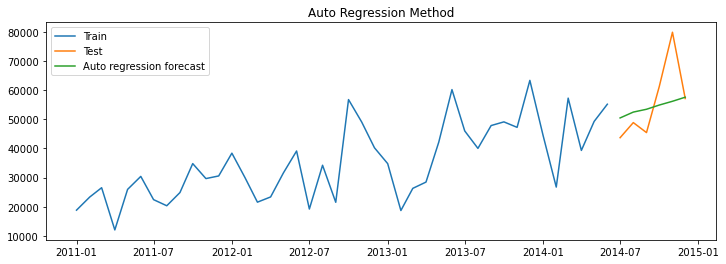

In [82]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

#### Plotting full prediction and not just for the next 6 months on test data:

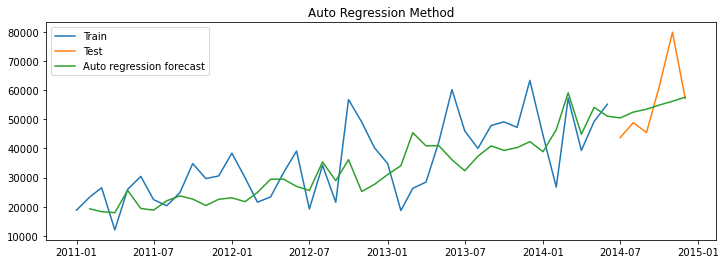

In [83]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ar['ar_forecast'], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

### Calculate RMSE and MAPE for AR method

In [84]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['(AR):Autoregressive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,14627.34,15.74
0,Holt's exponential smoothing method,12403.84,14.93
0,Holt Winters' additive method,9306.82,10.17
0,Holt Winters' multiplicative method,9423.23,11.43
0,(AR):Autoregressive method,10985.28,13.56


#### Inference:
- Compare apples to apples: AR Method should be compared with "Holt's exponential smoothing method" which captures level and trend as AR method too captures level and trend. We see that "AR method" is now performing better than "Holt's exponential smoothing method" in this case. As AR method has lesser RMSE and MAPE values

In [85]:
y_hat_ar.shape

(50,)

In [86]:
y_hat_ar.head()

Order_Date
2011-02-01 00:00:00       0.214
2011-03-01 00:00:00    0.128816
2011-04-01 00:00:00   -0.789102
2011-05-01 00:00:00    0.767119
2011-06-01 00:00:00    0.158548
dtype: object

In [87]:
print(type(y_hat_ar['ar_forecast']))

<class 'pandas.core.series.Series'>


In [88]:
test.shape

(6, 1)

#### Create Helper Functions to plot and calculate RMSE and MAPE for a new forecast by any specific method/model

In [89]:
# def cal_rmse_mape(forecast_Series,method_name):
#     rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
#     mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

#     tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
#     results = pd.concat([results, tempResults])
#     results = results[['Method', 'RMSE', 'MAPE']]
#     print(results)

## Moving average method (MA)
-  'q' which is the MA component of the order(0,0,0) as the highest lag beyond which autocorrelation dies down: 

In [90]:
#Note: Here we are passing 'train_data_boxcox_diff' to ARIMA method, as ARIMA method assumes/needs stationary timeseries data
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.021415
ma.L1.y   -1.000000
dtype: float64


### Recover original time series

In [91]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plot train, test and forecast for Moving Average- MA method

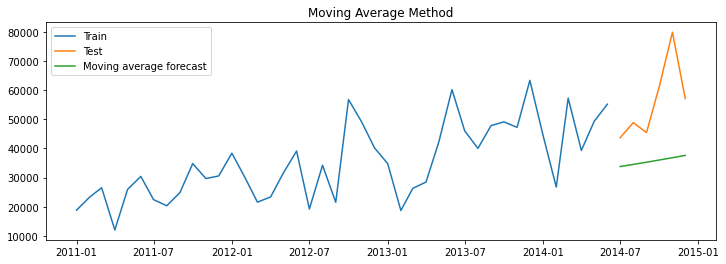

In [92]:
plt.figure(figsize=(12,4))
plt.plot(data['Sales'][:train_len], label='Train')
plt.plot(data['Sales'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

### Calculate RMSE and MAPE for Moving Average- MA method

In [93]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ma['ma_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['(MA):Moving Average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,14627.34,15.74
0,Holt's exponential smoothing method,12403.84,14.93
0,Holt Winters' additive method,9306.82,10.17
0,Holt Winters' multiplicative method,9423.23,11.43
0,(AR):Autoregressive method,10985.28,13.56
0,(MA):Moving Average method,23360.02,33.93


## Auto regression moving average method (ARMA)

In [94]:
#Note: Here we are passing 'train_data_boxcox_diff' to ARIMA method, as ARMA method assumes/needs stationary timeseries data
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      0.02147
ar.L1.y    0.07458
ma.L1.y   -1.00000
dtype: float64


### Recover original time series

In [95]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot train, test and forecast for ARMA:

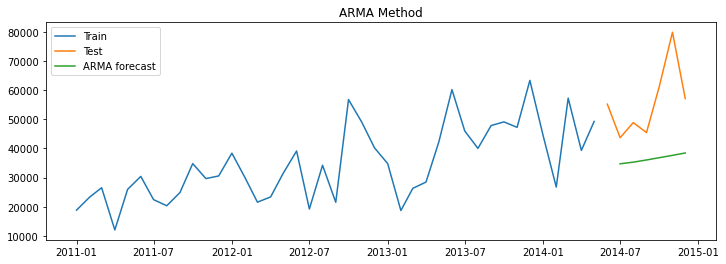

In [96]:
plt.figure(figsize=(12,4))
plt.plot( data['Sales'][:train_len-1], label='Train')
plt.plot(data['Sales'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

### Calculate RMSE and MAPE for ARMA:

In [97]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arma['arma_forecast'][train_len-1:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['(ARMA):Autoregressive moving average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,14627.34,15.74
0,Holt's exponential smoothing method,12403.84,14.93
0,Holt Winters' additive method,9306.82,10.17
0,Holt Winters' multiplicative method,9423.23,11.43
0,(AR):Autoregressive method,10985.28,13.56
0,(MA):Moving Average method,23360.02,33.93
0,(ARMA):Autoregressive moving average method,22654.32,32.40


#### Inference:
- Compare Apples to Apples
- We see ARMA method slightly better than MA methods
- However AR method does best when compared to MA and ARMA.
- ARMA Method to be compared with Holts Method and not Holt Winters Method as Holt Winters method captures seasonality. So we see ARMA under perform compared to "Holt's exponential smoothing method". As MAPE for ARMA is significantly high=`32.40`. which is higher that `14.93` MAPE value of "Holt's exponential smoothing method"

## Auto regressive integrated moving average (ARIMA)

#### To determine the parameters ‘p’, ‘d’ and ‘q’

- For ‘d’: Select d as the order of difference required to make the original time series stationary. We can verify if this differenced series is stationary or not by using the stationarity tests: ADF or KPSS test.
- For ‘p’ and ‘q’: Plot ACF and PACF of the 1st order differenced time series. Find the value of ‘p’ and ‘q’ as discussed previously with the earlier Auto Regressive Models.
- The last step in the ARIMA model is to recover the original time series forecast. 

In [98]:
#Note: Here we are passing 'train_data_boxcox' to ARIMA method, as ARIMA method assumes/needs stationary timeseries data
# Note: We are passing 'train_data_boxcox' and not 'train_data_boxcox_diff' as ARIMA does internal differencing by 'd' parameter
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.02147
ar.L1.D.y    0.07458
ma.L1.D.y   -1.00000
dtype: float64


#### Points to Observe in Above code:
- Here we are passing 'train_data_boxcox' to ARIMA method, as ARIMA method doesn't need an entire stationary timeseries data which is boxcoxed and differenced. It only needs data that is boxcoxed and not differenced as the model inherently handles differencing for you.
- You observe that the coefficients of ARMA and ARIMA have turned out to be the exact same values.
- Note: Below code when recovering we again use the whole 'data_boxcox_diff' and not just 'data_boxcox' as we have used 'train_data_boxcox' to train the model using ARIMA(1,1,1) but to predict or do our forescast we use the stationary data thats already available to use and use the model.predict() on this stationary data and then later perform reverse operations of cumsum() and exponential to get actual forecast values for the whole time series data set. We can than subset this forecast dataset to obtain only the test data forecast and plot it.

In [99]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot train, test and forecast for ARIMA:

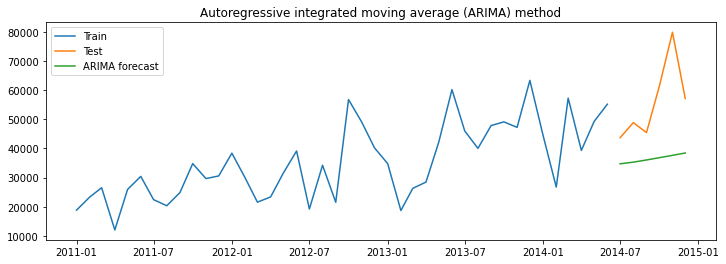

In [100]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

### Calculate RMSE and MAPE for ARIMA:

In [101]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['(ARIMA):Autoregressive integrated moving average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,14627.34,15.74
0,Holt's exponential smoothing method,12403.84,14.93
0,Holt Winters' additive method,9306.82,10.17
0,Holt Winters' multiplicative method,9423.23,11.43
0,(AR):Autoregressive method,10985.28,13.56
0,(MA):Moving Average method,23360.02,33.93
0,(ARMA):Autoregressive moving average method,22654.32,32.40
0,(ARIMA):Autoregressive integrated moving avera...,22654.32,32.40


#### Inference:
- Notice Metrics of RMSE and MAPE are exactly the same for ARMA and ARIMA
- This is because in ARMA we did manual differencing, in ARIMA we used internal differencing feature of ARIMA method

## Seasonal auto regressive integrated moving average (SARIMA): captures Seasonality too

In [102]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1      -0.041709
ma.L1      -0.997574
ar.S.L12    0.100440
ma.S.L12   -0.976602
sigma2      0.057963
dtype: float64


#### Inference from above:
- ar.L1=non seasonal(Trend) AR coeff
- ma.l1=non seasonal (Trend) MA coeff
- ar.S.L12= Seasonal AR coeff Here L12 refers to the 12 Seasonality. i.e 12 is the number of time steps for a single seasonal period.
- ma.S.L12= Seasonal MA coeff. Here L12 refers to the 12 Seasonality. i.e 12 is the number of time steps for a single seasonal period.

### Recover original time series forecast

In [103]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

#### Points to Observe:
- Here in SARIMA we don't perform the cumsum() i.e the integration as the model inherently does it for you. You just perform the unboxcox by performing the exponential function.

### Plot train, test and forecast for SARIMA:

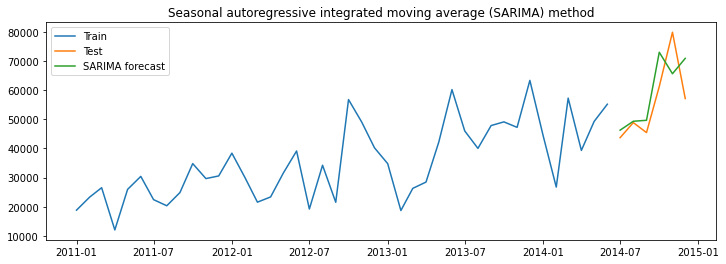

In [104]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

### Calculate RMSE and MAPE for SARIMA:

In [105]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['(SARIMA):Seasonal autoregressive integrated moving average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Simple exponential smoothing forecast,14627.34,15.74
0,Holt's exponential smoothing method,12403.84,14.93
0,Holt Winters' additive method,9306.82,10.17
0,Holt Winters' multiplicative method,9423.23,11.43
0,(AR):Autoregressive method,10985.28,13.56
0,(MA):Moving Average method,23360.02,33.93
0,(ARMA):Autoregressive moving average method,22654.32,32.40
0,(ARIMA):Autoregressive integrated moving avera...,22654.32,32.40
0,(SARIMA):Seasonal autoregressive integrated mo...,9618.73,12.88


## Final Inferences:
1. We see that in the Exponential Smoothing Methods "Holt Winters Additive Method" with RMSE(Root Mean Squared Error) of `9306.82` and MAPE(Mean Absolute Percentage Error) of `10.17` is the lowest compared to any other smoothing method. Thus we choose this method for our forecasting. This is also intuitively  obvious as "Holt Winters Additive Method" captured all three components of Level, Trend and Seasonality. This is also evident in the forecast plot that we saw above, as the Green Line(the forecast line) is quite close to the Yellow line(Actual Line).


2. In ARIMA methods we see that SARIMA method with RMSE of `9618.73` and MAPE of `12.88` is the lowest compared to other ARIMA methods. Thus we choose this method for our forecasting. This is also intuitively  obvious as "SARIMA" captured all three components of Level, Trend and Seasonality. This is also evident in the forecast plot that we saw above, , as the Green Line(the forecast line) is quite close to the Yellow line(Actual Line).


#### Thank you IIITB and Upgrad for the Learning Experience!
#### This File is Submitted by Achal Kagwad Date 5th July 2021

#### Project Complete
- This Project is done by `Achal Kagwad`
- Contact no: +91-9108302174
- Email Id: achal.kagwad@gmail.com
- Linked in: https://www.linkedin.com/in/achalkagwad/

---